In [1]:
#Bibliotecas
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
import pandas as pd
from skimage.feature import hog
#Machine Learning 
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
#Dl
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import tensorflow as tf
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

%matplotlib inline

Using TensorFlow backend.


In [2]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l):
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.2f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return(plt)

## DeepLearner Feature Extraction

In [3]:
modelo = models.load_model('estomato_InceptionResNetV2_final.h5')

/usr/local/lib/python2.7/dist-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
#modelo.pop()
modelo.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              39322624  
Total params: 93,659,360
Trainable params: 42,519,040
Non-trainable params: 51,140,320
_________________________________________________________________


In [5]:
dir_estomato = "/home/nagai/Documents/Projects/Estomatos_PI/Imagens/dataset/STOMA/"
dir_erro = "/home/nagai/Documents/Projects/Estomatos_PI/Imagens/dataset/ERRO/"

list_stoma = sorted(os.listdir(dir_estomato))
list_erro = sorted(os.listdir(dir_erro))
img_estomatos = []
img_erros = []


In [6]:
for i in list_stoma:
    img_estomatos.append(cv2.imread(dir_estomato+i))
for i in list_erro:
    img_erros.append(cv2.imread(dir_erro+i))


In [7]:
teste = np.array(cv2.resize(img_estomatos[0],(224,224)))


In [8]:
teste = teste.reshape(1,224,224,3)

In [9]:
modelo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              39322624  
Total params: 93,659,360
Trainable params: 42,519,040
Non-trainable params: 51,140,320
_________________________________________________________________


In [10]:
modelo.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
data = list()
for i in img_estomatos:
    resized_image = cv2.resize(i, (224, 224)) 
    ynew = modelo.predict(resized_image.reshape(1,224,224,3))
    tmp = np.append(ynew,1)
    data.append(tmp)
    
for i in img_erros:
    resized_image = cv2.resize(i, (224, 224)) 
    ynew = modelo.predict(resized_image.reshape(1,224,224,3))
    tmp = np.append(ynew,0)
    data.append(tmp)
 

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data['class'] = data[1024]
data['nome'] = list_stoma+list_erro
data = data.drop(columns=[1024])
data.to_csv('features_inceptionResNetV2.csv')

In [14]:
from sklearn.model_selection import StratifiedKFold
X = data.iloc[:,:-1]
y = data['class']
skf = StratifiedKFold(n_splits=5)
classifiers = [
    SVC(kernel="linear", C=0.025, probability=True),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
]
    
cls = ["SVM linear",
       "MLP",
       "AdaBoost",
]

In [15]:
fold = [[],[],[],[],[]]
k = 0
for i in range(0,2000,5):
    for j in range(5):
        fold[k%5].append(j+i)
    k+=1
tt1 = fold[0]+fold[1]+fold[2]+fold[3],fold[4]
tt2 = fold[1]+fold[2]+fold[3]+fold[4],fold[0]
tt3 = fold[0]+fold[2]+fold[3]+fold[4],fold[1]
tt4 = fold[0]+fold[1]+fold[3]+fold[4],fold[2]
tt5 = fold[0]+fold[1]+fold[2]+fold[4],fold[3]

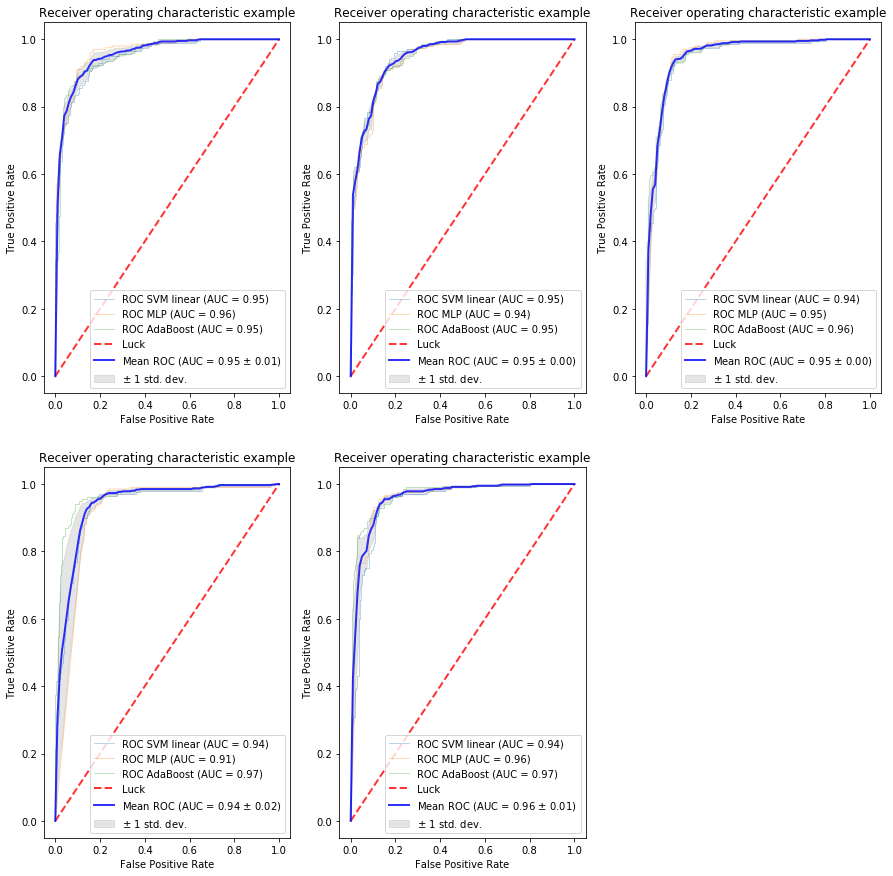

In [16]:
skf = StratifiedKFold(n_splits=5)
fig = plt.figure(figsize=(15,15))
row = 2
col = 3
i = 1
data_aux = data.iloc[:,:-1]
for train, test in [tt1,tt2,tt3,tt4,tt5]:
    tprs_dall = []
    aucs_dall = []
    mean_fpr_dall = np.linspace(0, 1, 100)
    a = fig.add_subplot(row, col, i)
    imgshow = roc(data_aux.iloc[train],data['class'][train],data_aux.iloc[test],data['class'][test], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
    i+=1